<a href="https://colab.research.google.com/github/zfurman56/black-hole/blob/main/black_hole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
from scipy.interpolate import interp1d
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from functools import partial
import os
from tqdm import tqdm
import cv2

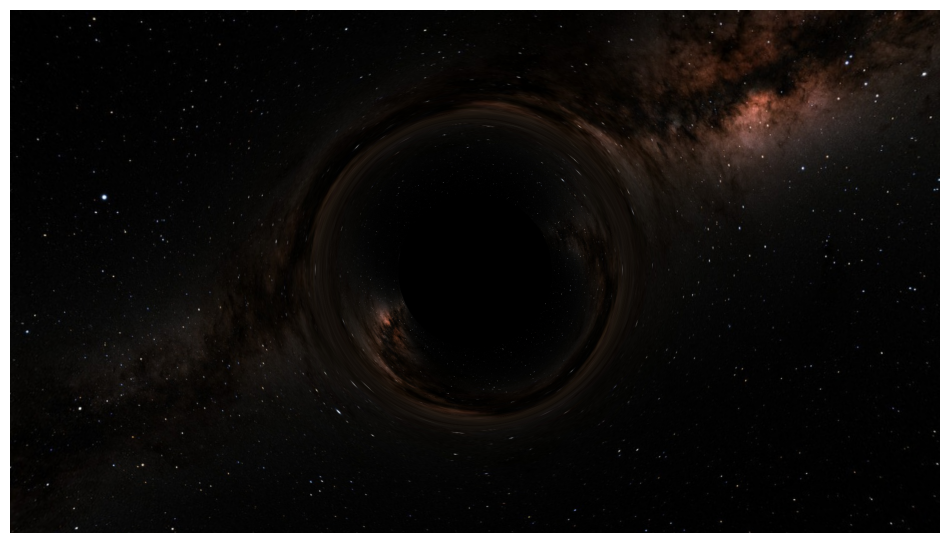

In [4]:
class SkyBox:
    def __init__(self, front, back, left, right, top, bottom):
        """Initialize skybox with six image paths for each face"""
        self.faces = {
            'front': np.array(Image.open(front)),
            'back': np.array(Image.open(back)),
            'left': np.array(Image.open(left)),
            'right': np.array(Image.open(right)),
            'top': np.array(Image.open(top)),
            'bottom': np.array(Image.open(bottom))
        }

        # Verify all images are the same size
        sizes = [img.shape for img in self.faces.values()]
        if len(set(str(s) for s in sizes)) != 1:
            raise ValueError("All skybox images must be the same size")

    def get_colors(self, directions, debug_mode=None, black_hole_mask=None):
        """
        Get colors from skybox given an array of direction vectors
        directions: numpy array of shape (..., 3) containing direction vectors
        debug_mode: None for normal rendering, or one of 'direction', 'face', 'uv'
        black_hole_mask: boolean array matching directions.shape[:-1], True where rays hit black hole
        returns: RGB colors as numpy array of shape (..., 3)
        """
        original_shape = directions.shape[:-1]

        # If we have a black hole mask, return black for those pixels first
        if black_hole_mask is not None:
            colors = np.zeros((*original_shape, 3), dtype=np.float32)
            # Only process non-black hole pixels
            valid_rays = ~black_hole_mask
            if np.any(valid_rays):
                colors[valid_rays] = self._get_skybox_colors(directions[valid_rays], debug_mode)
            return colors

        return self._get_skybox_colors(directions, debug_mode)

    def _get_skybox_colors(self, directions, debug_mode=None):
        original_shape = directions.shape[:-1]

        # Reshape to 2D array of directions
        flat_dirs = directions.reshape(-1, 3)

        # Normalize directions
        flat_dirs = flat_dirs / np.linalg.norm(flat_dirs, axis=1, keepdims=True)
        x, y, z = flat_dirs.T

        # Find dominant axis for each direction
        abs_x, abs_y, abs_z = np.abs(x), np.abs(y), np.abs(z)
        max_comp = np.maximum.reduce([abs_x, abs_y, abs_z])

        # Create boolean masks for each face
        is_right = (abs_x == max_comp) & (x > 0)
        is_left = (abs_x == max_comp) & (x <= 0)
        is_top = (abs_y == max_comp) & (y > 0)
        is_bottom = (abs_y == max_comp) & (y <= 0)
        is_front = (abs_z == max_comp) & (z > 0)
        is_back = (abs_z == max_comp) & (z <= 0)

        # If in debug mode, return visualization instead of actual colors
        if debug_mode == 'direction':
            # Map normalized direction vectors directly to RGB
            colors = (flat_dirs + 1) / 2 * 255
            return colors.reshape((*original_shape, 3))

        elif debug_mode == 'face':
            # Assign a distinct color to each face
            colors = np.zeros((len(flat_dirs), 3))
            colors[is_right] = [255, 0, 0]    # Red for right
            colors[is_left] = [0, 255, 0]     # Green for left
            colors[is_top] = [0, 0, 255]      # Blue for top
            colors[is_bottom] = [255, 255, 0]  # Yellow for bottom
            colors[is_front] = [255, 0, 255]   # Magenta for front
            colors[is_back] = [0, 255, 255]    # Cyan for back
            return colors.reshape((*original_shape, 3))

        # Initialize UV coordinates
        u = np.zeros_like(x)
        v = np.zeros_like(x)

        # Calculate UV coordinates for each face
        # Right face
        u[is_right] = -z[is_right]/x[is_right]
        v[is_right] = y[is_right]/x[is_right]

        # Left face
        u[is_left] = z[is_left]/abs_x[is_left]
        v[is_left] = y[is_left]/abs_x[is_left]

        # Top face
        u[is_top] = x[is_top]/y[is_top]
        v[is_top] = -z[is_top]/y[is_top]

        # Bottom face
        u[is_bottom] = x[is_bottom]/abs_y[is_bottom]
        v[is_bottom] = z[is_bottom]/abs_y[is_bottom]

        # Front face
        u[is_front] = x[is_front]/z[is_front]
        v[is_front] = y[is_front]/z[is_front]

        # Back face
        u[is_back] = -x[is_back]/abs_z[is_back]
        v[is_back] = y[is_back]/abs_z[is_back]

        if debug_mode == 'uv':
            # Map UV coordinates to RG (B=0)
            colors = np.zeros((len(flat_dirs), 3))
            colors[:, 0] = ((u + 1) / 2 * 255)  # R = U
            colors[:, 1] = ((v + 1) / 2 * 255)  # G = V
            return colors.reshape((*original_shape, 3))

        # Convert [-1,1] coordinates to pixel coordinates (as floats)
        height, width = next(iter(self.faces.values())).shape[:2]
        px = (u + 1) * (width - 1) / 2
        py = (v + 1) * (height - 1) / 2

        # Get integer and fractional parts for interpolation
        px0 = np.floor(px).astype(np.int32)
        py0 = np.floor(py).astype(np.int32)
        px1 = np.minimum(px0 + 1, width - 1)
        py1 = np.minimum(py0 + 1, height - 1)

        # Calculate interpolation weights
        wx1 = px - px0
        wy1 = py - py0
        wx0 = 1 - wx1
        wy0 = 1 - wy1

        # Initialize output array
        colors = np.zeros((len(flat_dirs), 3), dtype=np.float32)

        # Sample colors from each face with bilinear interpolation
        for face_name, mask in [
            ('right', is_right),
            ('left', is_left),
            ('top', is_top),
            ('bottom', is_bottom),
            ('front', is_front),
            ('back', is_back)
        ]:
            if np.any(mask):
                face = self.faces[face_name].astype(np.float32)

                # Get the four nearest pixels for each point
                c00 = face[py0[mask], px0[mask]]
                c01 = face[py1[mask], px0[mask]]
                c10 = face[py0[mask], px1[mask]]
                c11 = face[py1[mask], px1[mask]]

                # Compute bilinear interpolation
                colors[mask] = (wx0[mask, np.newaxis] * wy0[mask, np.newaxis] * c00 +
                              wx0[mask, np.newaxis] * wy1[mask, np.newaxis] * c01 +
                              wx1[mask, np.newaxis] * wy0[mask, np.newaxis] * c10 +
                              wx1[mask, np.newaxis] * wy1[mask, np.newaxis] * c11)

        # Reshape back to original dimensions
        return np.clip(colors, 0, 255).reshape((*original_shape, 3))


def look_at_matrix(eye, target=np.array([0., 0., 0.]), up=np.array([0., 1., 0.])):
    """
    Generate a rotation matrix that looks from eye towards target
    eye: camera position
    target: point to look at
    up: up vector
    returns: 3x3 rotation matrix
    """
    forward = target - eye
    forward = forward / np.linalg.norm(forward)

    right = np.cross(forward, up)
    right = right / np.linalg.norm(right)

    new_up = np.cross(right, forward)
    new_up = new_up / np.linalg.norm(new_up)

    # Construct rotation matrix
    rotation_matrix = np.array([
        right,
        new_up,
        forward
    ]).T

    return rotation_matrix

def generate_rays(fov_degrees, aspect_ratio, image_width, rotation_matrix=None):
    """
    Generate ray directions for each pixel
    fov_degrees: vertical field of view in degrees
    aspect_ratio: width/height of the output image
    image_width: width of the output image in pixels
    rotation_matrix: optional 3x3 rotation matrix to apply to rays
    returns: array of shape (height, width, 3) containing ray directions
    """
    image_height = int(image_width / aspect_ratio)

    # Convert FOV to radians and calculate image plane dimensions
    fov = np.radians(fov_degrees)
    image_plane_height = 2 * np.tan(fov/2)
    image_plane_width = image_plane_height * aspect_ratio

    # Create pixel coordinate grid
    x = np.linspace(-image_plane_width/2, image_plane_width/2, image_width)
    y = np.linspace(image_plane_height/2, -image_plane_height/2, image_height)
    xx, yy = np.meshgrid(x, y)

    # Create ray directions (assuming camera at origin looking in +z direction)
    directions = np.zeros((image_height, image_width, 3))
    directions[:, :, 0] = xx  # x component
    directions[:, :, 1] = yy  # y component
    directions[:, :, 2] = 1.0  # z component

    # Normalize directions
    norm = np.sqrt(np.sum(directions**2, axis=2))
    directions /= norm[:, :, np.newaxis]

    # Apply rotation if provided
    if rotation_matrix is not None:
        # Reshape for matrix multiplication
        flat_dirs = directions.reshape(-1, 3)
        rotated_dirs = np.dot(flat_dirs, rotation_matrix.T)
        directions = rotated_dirs.reshape(directions.shape)

    return directions

@jax.jit
def schwarzschild_christoffel(coords, mass):
    """
    Calculate Schwarzschild metric Christoffel symbols in Eddington-Finkelstein
    coordinates for given coordinates and mass. For efficiency, accepts batches
    of coordinates, and returns batches of Christoffel symbols.
    coords: array of Eddington-Finkelstein coordinates with shape (n, 4) where
           each row is (v, r, theta, phi)
    mass: mass of the source
    returns: array of Christoffel symbols with shape (n, 4, 4, 4)
    """
    v = coords[:, 0]
    r = coords[:, 1]
    theta = coords[:, 2]
    phi = coords[:, 3]

    # Create template arrays for each coordinate component
    zeros = jnp.zeros_like(r)

    # Create each 4x4 slice as a JAX array
    gamma_v = jnp.transpose(jnp.array([
        [mass/r**2, zeros, zeros, zeros],
        [zeros, zeros, zeros, zeros],
        [zeros, zeros, -r, zeros],
        [zeros, zeros, zeros, -r*jnp.sin(theta)**2]
    ]), (2, 0, 1))

    gamma_r = jnp.transpose(jnp.array([
        [mass*(-2*mass + r)/r**3, -mass/r**2, zeros, zeros],
        [-mass/r**2, zeros, zeros, zeros],
        [zeros, zeros, 2*mass - r, zeros],
        [zeros, zeros, zeros, (2*mass - r)*jnp.sin(theta)**2]
    ]), (2, 0, 1))

    gamma_theta = jnp.transpose(jnp.array([
        [zeros, zeros, zeros, zeros],
        [zeros, zeros, 1/r, zeros],
        [zeros, 1/r, zeros, zeros],
        [zeros, zeros, zeros, -jnp.sin(2*theta)/2]
    ]), (2, 0, 1))

    gamma_phi = jnp.transpose(jnp.array([
        [zeros, zeros, zeros, zeros],
        [zeros, zeros, zeros, 1/r],
        [zeros, zeros, zeros, 1/jnp.tan(theta)],
        [zeros, 1/r, 1/jnp.tan(theta), zeros]
    ]), (2, 0, 1))

    # Stack all components and transpose to get correct shape
    return jnp.stack([gamma_v, gamma_r, gamma_theta, gamma_phi], axis=1)

@jax.jit
def cartesian_to_spherical(coords, vel=None):
    """
    Convert Cartesian coordinates (and optionally velocities) to spherical coordinates
    coords: array of Cartesian coordinates with shape (n, 3) or (3,)
    vel: optional array of velocities with shape (n, 3) or (3,)
    returns: if vel is None, returns spherical coordinates with shape (n, 3) or (3,)
            otherwise returns tuple of (spherical_coords, spherical_vel)
    """
    coords = jnp.atleast_2d(coords)
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]

    # Calculate spherical coordinates
    r = jnp.sqrt(x**2 + y**2 + z**2)
    theta = jnp.arccos(z / r)
    phi = jnp.arctan2(y, x)
    coords_sph = jnp.stack([r, theta, phi], axis=1)

    if vel is None:
        return jnp.squeeze(coords_sph)

    # Handle velocity conversion if provided
    vel = jnp.atleast_2d(vel)
    vx, vy, vz = vel[:, 0], vel[:, 1], vel[:, 2]

    # Calculate velocity components in spherical coordinates
    xy_sq = x**2 + y**2

    # v_r = (x*vx + y*vy + z*vz)/r
    v_r = (x * vx + y * vy + z * vz) / r

    # v_theta = (z*(x*vx + y*vy) - (x^2 + y^2)*vz)/(r^2 * sqrt(x^2 + y^2))
    v_theta = (z * (x * vx + y * vy) - xy_sq * vz) / (r**2 * jnp.sqrt(xy_sq))

    # v_phi = (x*vy - y*vx)/(x^2 + y^2)
    v_phi = (x * vy - y * vx) / xy_sq

    vel_sph = jnp.stack([v_r, v_theta, v_phi], axis=1)

    return jnp.squeeze(coords_sph), jnp.squeeze(vel_sph)

@jax.jit
def spherical_to_cartesian(coords, vel=None):
    """
    Convert spherical coordinates (and optionally velocities) to Cartesian coordinates
    coords: array of spherical coordinates with shape (n, 3) or (3,)
    vel: optional array of velocities with shape (n, 3) or (3,)
    returns: if vel is None, returns Cartesian coordinates with shape (n, 3) or (3,)
            otherwise returns tuple of (cartesian_coords, cartesian_vel)
    """
    coords = jnp.atleast_2d(coords)
    r, theta, phi = coords[:, 0], coords[:, 1], coords[:, 2]

    # Calculate Cartesian coordinates
    sin_theta = jnp.sin(theta)
    cos_theta = jnp.cos(theta)
    sin_phi = jnp.sin(phi)
    cos_phi = jnp.cos(phi)

    x = r * sin_theta * cos_phi
    y = r * sin_theta * sin_phi
    z = r * cos_theta
    coords_cart = jnp.stack([x, y, z], axis=1)

    if vel is None:
        return jnp.squeeze(coords_cart)

    # Handle velocity conversion if provided
    vel = jnp.atleast_2d(vel)
    v_r, v_theta, v_phi = vel[:, 0], vel[:, 1], vel[:, 2]

    # Calculate Cartesian velocities
    # vx = v_r * sin(θ)cos(φ) + v_θ * r cos(θ)cos(φ) - v_φ * r sin(θ)sin(φ)
    vx = v_r * sin_theta * cos_phi + v_theta * r * cos_theta * cos_phi - v_phi * r * sin_theta * sin_phi

    # vy = v_r * sin(θ)sin(φ) + v_θ * r cos(θ)sin(φ) + v_φ * r sin(θ)cos(φ)
    vy = v_r * sin_theta * sin_phi + v_theta * r * cos_theta * sin_phi + v_phi * r * sin_theta * cos_phi

    # vz = v_r * cos(θ) - v_θ * sin(θ)
    vz = v_r * cos_theta - v_theta * r * sin_theta

    vel_cart = jnp.stack([vx, vy, vz], axis=1)

    return jnp.squeeze(coords_cart), jnp.squeeze(vel_cart)

@jax.jit
def cartesian_to_eddin(coords, mass, vel=None):
    """
    Convert 4D Cartesian coordinates (and optionally velocities) to Eddington-Finkelstein coordinates
    coords: array of Cartesian coordinates with shape (n, 4) or (4,)
    mass: mass of the source
    vel: optional array of velocities with shape (n, 4) or (4,)
    returns: if vel is None, returns Eddington-Finkelstein coordinates with shape (n, 4) or (4,)
            otherwise returns tuple of (eddin_coords, eddin_vel)
    """
    coords = jnp.atleast_2d(coords)
    t = coords[:, 0]
    spatial_coords = coords[:, 1:]

    if vel is None:
        rthetaphi = jnp.atleast_2d(cartesian_to_spherical(spatial_coords))
        r = rthetaphi[:, 0]
        r_tortoise = r + 2*mass*jnp.log(jnp.abs(r - 2*mass))
        eddin_coords = jnp.concatenate([jnp.expand_dims(t + r_tortoise, 1), rthetaphi], axis=1)
        return jnp.squeeze(eddin_coords)

    # Handle velocity conversion if provided
    vel = jnp.atleast_2d(vel)
    vt = vel[:, 0]
    spatial_vel = vel[:, 1:]

    # Get both coordinates and velocities in spherical form
    rthetaphi, v_rthetaphi = cartesian_to_spherical(spatial_coords, spatial_vel)
    rthetaphi, v_rthetaphi = jnp.atleast_2d(rthetaphi), jnp.atleast_2d(v_rthetaphi)
    r = rthetaphi[:, 0]
    v_r = v_rthetaphi[:, 0]

    # Calculate advanced time coordinate v and its derivative
    r_tortoise = r + 2*mass*jnp.log(jnp.abs(r - 2*mass))
    # dv/dr = 1 + 2M/(r - 2M)
    dr_tortoise_dr = 1 + 2*mass/(r - 2*mass)

    # Calculate advanced time velocity
    v_adv = vt + dr_tortoise_dr * v_r

    # Combine into final coordinates and velocities
    eddin_coords = jnp.concatenate([jnp.expand_dims(t + r_tortoise, 1), rthetaphi], axis=1)
    eddin_vel = jnp.concatenate([jnp.expand_dims(v_adv, 1), v_rthetaphi], axis=1)

    return jnp.squeeze(eddin_coords), jnp.squeeze(eddin_vel)

@jax.jit
def eddin_to_cartesian(coords, mass, vel=None):
    """
    Convert Eddington-Finkelstein coordinates (and optionally velocities) to 4D Cartesian coordinates
    coords: array of Eddington-Finkelstein coordinates with shape (n, 4) or (4,)
    mass: mass of the source
    vel: optional array of velocities with shape (n, 4) or (4,)
    returns: if vel is None, returns Cartesian coordinates with shape (n, 4) or (4,)
            otherwise returns tuple of (cartesian_coords, cartesian_vel)
    """
    coords = jnp.atleast_2d(coords)
    v, r = coords[:, 0], coords[:, 1]

    # Calculate Schwarzschild time
    t = v - r - 2*mass*jnp.log(jnp.abs(r - 2*mass))

    if vel is None:
        # Convert spatial coordinates to Cartesian
        xyz = jnp.atleast_2d(spherical_to_cartesian(coords[:, 1:]))
        cartesian_coords = jnp.concatenate([jnp.expand_dims(t, 1), xyz], axis=1)
        return jnp.squeeze(cartesian_coords)

    # Handle velocity conversion if provided
    vel = jnp.atleast_2d(vel)
    v_v, v_r = vel[:, 0], vel[:, 1]

    # Calculate time velocity using chain rule
    # dt/dv = 1
    # dt/dr = -1 - 2M/(r-2M)
    dr_tortoise_dr = 1 + 2*mass/(r - 2*mass)
    v_t = v_v - dr_tortoise_dr * v_r

    # Convert spatial coordinates and velocities to Cartesian
    xyz, v_xyz = spherical_to_cartesian(coords[:, 1:], vel[:, 1:])
    xyz, v_xyz = jnp.atleast_2d(xyz), jnp.atleast_2d(v_xyz)

    # Combine into final coordinates and velocities
    cartesian_coords = jnp.concatenate([jnp.expand_dims(t, 1), xyz], axis=1)
    cartesian_vel = jnp.concatenate([jnp.expand_dims(v_t, 1), v_xyz], axis=1)

    return jnp.squeeze(cartesian_coords), jnp.squeeze(cartesian_vel)

@jax.jit
def sim_step(pos_eddin, vel_eddin, black_hole_mass, step_size):
      christoffel = schwarzschild_christoffel(pos_eddin, black_hole_mass)
      vel_eddin = vel_eddin + step_size * -jnp.einsum('bikl,bk,bl->bi', christoffel, vel_eddin, vel_eddin)
      pos_eddin = pos_eddin + step_size * vel_eddin
      vel_eddin = vel_eddin * (pos_eddin[:, 1:2] > (2*black_hole_mass))
      return pos_eddin, vel_eddin

def simulate_rays(camera_position,
                  ray_directions,
                  black_hole_mass,
                  black_hole_position=jnp.array([0., 0., 0.]),
                  step_size=0.01,
                  num_steps=1000):
    num_rays = ray_directions.shape[0]
    observer_position = camera_position - black_hole_position
    black_hole_direction = -observer_position / np.linalg.norm(observer_position)

    pos_cartesian = jnp.concatenate([jnp.array([0.0]), observer_position])
    pos_cartesian = jnp.broadcast_to(pos_cartesian, (num_rays, 4))
    vel_cartesian = jnp.concatenate([jnp.sqrt(2) * jnp.ones((num_rays, 1)), ray_directions], axis=1)
    vel_norm = jnp.sqrt(-jnp.sum(vel_cartesian * jnp.array([-1, 1, 1, 1]) * vel_cartesian, axis=1, keepdims=True))
    vel_cartesian = vel_cartesian / vel_norm

    pos_eddin, vel_eddin = cartesian_to_eddin(pos_cartesian, black_hole_mass, vel_cartesian)

    pos_eddin, vel_eddin = jax.lax.fori_loop(
        0, num_steps, lambda i, val: sim_step(*val, black_hole_mass, step_size), (pos_eddin, vel_eddin)
    )

    #for i in range(num_steps):
    #    pos_eddin, vel_eddin = sim_step(pos_eddin, vel_eddin, black_hole_mass, step_size)
#
    #    #if i % 100 == 0:
    #    #    print(f"Step {i}/{num_steps}")

    pos_cartesian2, vel_cartesian2 = eddin_to_cartesian(pos_eddin, black_hole_mass, vel_eddin)
    vel_norm2 = jnp.sqrt(-jnp.sum(vel_cartesian2 * jnp.array([-1, 1, 1, 1]) * vel_cartesian2, axis=1, keepdims=True))
    vel_cartesian2 = vel_cartesian2 / vel_norm2

    #print("Initial positions:")
    #print(pos_cartesian)
    #print("Initial velocities:")
    #print(vel_cartesian)
    #print("Final positions:")
    #print(pos_cartesian2)
    #print("Final velocities:")
    #print(vel_cartesian2)

    ray_directions = vel_cartesian2[:, 1:]

    black_hole_collisions = np.linalg.norm(vel_eddin, axis=-1) < 0.01

    return ray_directions, black_hole_collisions

def visualize_ray_directions(ray_directions):
    import plotly.graph_objects as go

    # Reshape ray directions to 1D array of vectors
    flat_dirs = ray_directions.reshape(-1, 3)

    # Create scatter plot of ray directions
    fig = go.Figure(data=[
        go.Scatter3d(
            x=flat_dirs[:, 0],
            y=flat_dirs[:, 1],
            z=flat_dirs[:, 2],
            mode='markers',
            marker=dict(
                size=2,
                color=flat_dirs[:, 2],  # Color by z-coordinate
                colorscale='Viridis'
            )
        )
    ])

    # Add unit sphere for reference
    phi = np.linspace(0, 2*np.pi, 100)
    theta = np.linspace(0, np.pi, 100)
    phi, theta = np.meshgrid(phi, theta)

    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    fig.add_trace(go.Scatter3d(
        x=x.flatten(),
        y=y.flatten(),
        z=z.flatten(),
        mode='markers',
        marker=dict(
            size=1,
            color='gray',
            opacity=0.1
        ),
        name='Unit Sphere'
    ))

    # Update layout
    fig.update_layout(
        scene=dict(
            aspectmode='cube',
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        width=800,
        height=800,
        title='Ray Directions Distribution'
    )

    fig.show()

def render_image(skybox,
                         camera_position,
                         black_hole_mass=0.5,
                         fov_degrees=90,
                         image_width=400,
                         target=None,
                         up=np.array([0., 1., 0.])):
    aspect_ratio = 16/9
    image_height = int(image_width / aspect_ratio)

    # Set up camera rotation
    if target is None:
        target = np.array([0., 0., 0.])
    rotation_matrix = look_at_matrix(camera_position, target, up)

    # Generate 2D slice through image plane at z=1
    fov = np.radians(fov_degrees)
    image_plane_height = np.tan(fov/2)
    image_plane_width = image_plane_height * aspect_ratio
    image_plane_diag = np.sqrt(image_plane_height**2 + image_plane_width**2)

    # Create y coordinates for vertical slice (x=0, z=1)
    y = np.linspace(0, image_plane_diag, image_width)

    # Create vectors through image plane
    directions_2d = np.zeros((image_width, 3))
    directions_2d[:, 1] = y  # y component
    directions_2d[:, 2] = 1.0  # z component
    _, init_theta, _ = cartesian_to_spherical(directions_2d).T

    # Normalize to get unit vectors
    directions_2d /= np.sqrt(np.sum(directions_2d**2, axis=1))[:, np.newaxis]

    # Apply camera rotation
    ray_directions_2d = np.dot(directions_2d, rotation_matrix.T)

    # Simulate these rays
    final_directions_2d, collisions_2d = simulate_rays(camera_position, ray_directions_2d, black_hole_mass)

    #visualize_ray_directions(final_directions_2d)

    # Switch back to camera coordinates
    final_directions_2d = np.dot(final_directions_2d, rotation_matrix)
    final_directions_2d_sph = cartesian_to_spherical(final_directions_2d)

    # Map screen rays to simulated rays via their theta coordinate, leveraging spherical solution symmetry
    screen_rays = generate_rays(fov_degrees, aspect_ratio, image_width).reshape(-1, 3)
    _, screen_theta, screen_phi = cartesian_to_spherical(screen_rays).T
    result_directions_sph = interp1d(init_theta, final_directions_2d_sph, axis=0)(screen_theta)
    result_directions_sph[:, 2] = result_directions_sph[:, 2] + screen_phi
    result_directions = spherical_to_cartesian(result_directions_sph)

    # Interpolate collision mask along with directions
    result_collisions = np.round(interp1d(init_theta, collisions_2d, axis=0)(screen_theta)).astype(bool)
    result_collisions = result_collisions.reshape(image_height, image_width)

    # Switch back to world coordinates and reshape
    result_directions = np.dot(result_directions, rotation_matrix.T).reshape(image_height, image_width, 3)

    # Get colors from skybox
    image = skybox.get_colors(result_directions, black_hole_mask=result_collisions, debug_mode=None)

    return image.astype(np.uint8)

skybox = SkyBox(
    front='skybox/front.jpg',
    back='skybox/back.jpg',
    left='skybox/left.jpg',
    right='skybox/right.jpg',
    top='skybox/top.jpg',
    bottom='skybox/bottom.jpg'
)

camera_position = np.array([9., 0., 3.])  # Place camera at an angle
target = np.array([0., 0., 0.])  # Look at origin
up = np.array([0., 1., 0.])  # Keep "up" direction vertical

image = render_image(skybox, camera_position, image_width=1920, target=target, up=up)

# Display result
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
def create_orbit_animation(skybox,
                         radius=9.0,
                         height=3.0,
                         num_frames=30,
                         image_width=400,
                         output_path='black_hole_orbit.gif',
                         duration=100,  # duration per frame in milliseconds
                         fps=30):       # frames per second for MP4
    """
    Create an animation of orbiting around a black hole

    Parameters:
    skybox: SkyBox instance
    radius: orbital radius
    height: height above orbital plane
    num_frames: number of frames in the animation
    image_width: width of each frame in pixels
    output_path: path to save the output (supports .gif and .mp4)
    duration: duration of each frame in milliseconds (for GIF only)
    fps: frames per second (for MP4 only)
    """

    # Create temporary directory for frames
    os.makedirs('temp_frames', exist_ok=True)

    frames = []
    angles = np.linspace(0, 2*np.pi, num_frames, endpoint=False)

    # Determine output format
    is_mp4 = output_path.lower().endswith('.mp4')

    if is_mp4:
        # Initialize video writer
        frame_size = (image_width, int(image_width / (16/9)))
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, frame_size)

    print("Generating frames...")
    for i, angle in enumerate(tqdm(angles)):
        # Calculate camera position for this frame
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        z = height
        camera_position = np.array([x, y, z])

        # Look at origin
        target = np.array([0., 0., 0.])
        up = np.array([0., 1., 0.])  # Keep "up" direction vertical

        # Render frame
        frame = render_image(skybox,
                           camera_position=camera_position,
                           target=target,
                           up=up,
                           image_width=image_width)

        if is_mp4:
            # OpenCV uses BGR format
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(frame_bgr)
        else:
            # Convert to PIL Image for GIF
            frames.append(Image.fromarray(frame))

        # Save frame (optional, for debugging)
        frame_path = f'temp_frames/frame_{i:03d}.png'
        Image.fromarray(frame).save(frame_path)

    if is_mp4:
        print("Creating MP4...")
        out.release()
    else:
        print("Creating GIF...")
        # Save as GIF
        frames[0].save(
            output_path,
            save_all=True,
            append_images=frames[1:],
            duration=duration,
            loop=0  # 0 means loop forever
        )

    print(f"Animation saved to {output_path}")

    # Cleanup temporary frames
    for file in os.listdir('temp_frames'):
        os.remove(os.path.join('temp_frames', file))
    os.rmdir('temp_frames')


skybox = SkyBox(
    front='skybox/front.jpg',
    back='skybox/back.jpg',
    left='skybox/left.jpg',
    right='skybox/right.jpg',
    top='skybox/top.jpg',
    bottom='skybox/bottom.jpg'
)

# Create MP4
create_orbit_animation(skybox,
                      radius=9.0,
                      height=3.0,
                      image_width=1920,
                      num_frames=240,  # More frames for smoother video
                      output_path='black_hole_orbit.mp4',
                      fps=30)

Generating frames...


 45%|████▍     | 107/240 [06:24<07:14,  3.27s/it]

In [51]:
import sympy as sp

# Define coordinates and parameters
v, r, theta, phi, M = sp.symbols('v r theta phi M')
coords = [v, r, theta, phi]

# Define the metric components
# Lower metric g_μν
g = sp.Matrix([
    [-(1 - 2*M/r), 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, r**2, 0],
    [0, 0, 0, r**2 * sp.sin(theta)**2]
])

# Upper metric g^μν
g_up = sp.Matrix([
    [0, 1, 0, 0],
    [1, 1-2*M/r, 0, 0],
    [0, 0, 1/r**2, 0],
    [0, 0, 0, 1/(r**2 * sp.sin(theta)**2)]
])

# Function to calculate partial derivative of metric with respect to coordinate
def partial_deriv(g, coord):
    return sp.diff(g, coord)

# Calculate all partial derivatives of metric components
dg = {(mu, nu, sigma): partial_deriv(g[mu,nu], coords[sigma])
      for mu in range(4)
      for nu in range(4)
      for sigma in range(4)}

# Calculate Christoffel symbols
christoffel = {(alpha, beta, gamma): 0
              for alpha in range(4)
              for beta in range(4)
              for gamma in range(4)}

for alpha in range(4):
    for beta in range(4):
        for gamma in range(4):
            sum_term = 0
            for delta in range(4):
                term = g_up[alpha,delta] * (
                    dg[(delta,gamma,beta)] +
                    dg[(delta,beta,gamma)] -
                    dg[(beta,gamma,delta)]
                ) / 2
                sum_term += term
            if sum_term != 0:
                christoffel[(alpha,beta,gamma)] = sum_term.simplify()

# Print non-zero Christoffel symbols
print("Non-zero Christoffel symbols:")
for key, value in christoffel.items():
    if value != 0:
        alpha, beta, gamma = key
        print(f"Γ^{alpha}_{{{beta}{gamma}}} = {value}")

Non-zero Christoffel symbols:
Γ^0_{00} = M/r**2
Γ^0_{22} = -r
Γ^0_{33} = -r*sin(theta)**2
Γ^1_{00} = M*(-2*M + r)/r**3
Γ^1_{01} = -M/r**2
Γ^1_{10} = -M/r**2
Γ^1_{22} = 2*M - r
Γ^1_{33} = (2*M - r)*sin(theta)**2
Γ^2_{12} = 1/r
Γ^2_{21} = 1/r
Γ^2_{33} = -sin(2*theta)/2
Γ^3_{13} = 1/r
Γ^3_{23} = 1/tan(theta)
Γ^3_{31} = 1/r
Γ^3_{32} = 1/tan(theta)
